In [1]:
"""
lightgbm有监督二分类训练Demo
"""

'\nlightgbm\xe6\x9c\x89\xe7\x9b\x91\xe7\x9d\xa3\xe4\xba\x8c\xe5\x88\x86\xe7\xb1\xbb\xe8\xae\xad\xe7\xbb\x83Demo\n'

In [2]:
import json
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

try:
    import cPickle as pickle
except BaseException:
    import pickle

import matplotlib.pyplot as plt
%matplotlib inline

## 加载数据

In [3]:
print('Loading data...')
df_train = pd.read_csv('binary.train', header=None, sep='\t')
df_test = pd.read_csv('binary.test', header=None, sep='\t')
W_train = pd.read_csv('binary.train.weight', header=None)[0]
W_test = pd.read_csv('binary.test.weight', header=None)[0]

Loading data...


In [4]:
len(list(W_test))

500

In [5]:
df_test.shape

(500, 29)

In [6]:
y_train = df_train[0]
y_test = df_test[0]
X_train = df_train.drop(0, axis=1)
X_test = df_test.drop(0, axis=1)

In [7]:
# 赋值特征名称
num_train, num_feature = X_train.shape

feature_name = ['feature_' + str(col) for col in range(num_feature)]
X_train.columns = feature_name

In [8]:
X_train

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27
0,0.869,-0.635,0.226,0.327,-0.690,0.754,-0.249,-1.092,0.000,1.375,...,-0.010,-0.046,3.102,1.354,0.980,0.978,0.920,0.722,0.989,0.877
1,0.908,0.329,0.359,1.498,-0.313,1.096,-0.558,-1.588,2.173,0.813,...,-1.139,-0.001,0.000,0.302,0.833,0.986,0.978,0.780,0.992,0.798
2,0.799,1.471,-1.636,0.454,0.426,1.105,1.282,1.382,0.000,0.852,...,1.129,0.900,0.000,0.910,1.108,0.986,0.951,0.803,0.866,0.780
3,1.344,-0.877,0.936,1.992,0.882,1.786,-1.647,-0.942,0.000,2.423,...,-0.678,-1.360,0.000,0.947,1.029,0.999,0.728,0.869,1.027,0.958
4,1.105,0.321,1.522,0.883,-1.205,0.681,-1.070,-0.922,0.000,0.801,...,-0.374,0.113,0.000,0.756,1.361,0.987,0.838,1.133,0.872,0.808
5,1.596,-0.608,0.007,1.818,-0.112,0.848,-0.566,1.581,2.173,0.755,...,-0.654,-1.274,3.102,0.824,0.938,0.972,0.789,0.431,0.961,0.958
6,0.409,-1.885,-1.027,1.672,-1.605,1.338,0.055,0.013,2.173,0.510,...,0.069,1.377,3.102,0.869,1.222,1.001,0.545,0.699,0.977,0.829
7,0.934,0.629,0.528,0.238,-0.967,0.548,-0.059,-1.707,2.173,0.941,...,1.291,-1.467,0.000,0.902,1.084,0.980,0.783,0.849,0.894,0.775
8,1.405,0.537,0.690,1.180,-0.110,3.202,-1.527,-1.576,0.000,2.932,...,-0.151,1.163,0.000,1.667,4.039,1.176,1.045,1.543,3.535,2.741
9,1.177,0.104,1.397,0.480,0.266,1.136,1.535,-0.253,0.000,1.027,...,0.269,0.530,0.000,0.833,0.774,0.986,1.104,0.849,0.937,0.812


## 1.lgb.LGBMClassifier sklearn API 训练

In [9]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
#     'num_leaves': 31,
    'max_depth': 5,
    'learning_rate': 0.1,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 2,
    'lambda_l1': 0.25,
    'lambda_l2': 0.25,
    'verbose': 0,
    'n_estimators': 5000,
    'min_child_weight': 5,
    'random_state': 2019,
    'category_feature': ['feature_20'],  # 指定类别特征
    'n_jobs': 32
}

In [10]:
lgb_model = lgb.LGBMClassifier(**params)

lgb_model.fit(X_train, 
              y_train, 
              eval_set = [(X_train, y_train), (X_test, y_test)], 
              early_stopping_rounds=50, 
              feature_name = feature_name,
              sample_weight = W_train)

[1]	training's auc: 0.730002	valid_1's auc: 0.73602
Training until validation scores don't improve for 50 rounds.
[2]	training's auc: 0.757091	valid_1's auc: 0.768858
[3]	training's auc: 0.771177	valid_1's auc: 0.778831
[4]	training's auc: 0.780585	valid_1's auc: 0.776122
[5]	training's auc: 0.788226	valid_1's auc: 0.77792
[6]	training's auc: 0.800514	valid_1's auc: 0.794561
[7]	training's auc: 0.80422	valid_1's auc: 0.797165
[8]	training's auc: 0.807967	valid_1's auc: 0.797988
[9]	training's auc: 0.81016	valid_1's auc: 0.796222
[10]	training's auc: 0.810966	valid_1's auc: 0.794093
[11]	training's auc: 0.813551	valid_1's auc: 0.796964
[12]	training's auc: 0.815217	valid_1's auc: 0.797544
[13]	training's auc: 0.817789	valid_1's auc: 0.800261
[14]	training's auc: 0.819329	valid_1's auc: 0.799769
[15]	training's auc: 0.821601	valid_1's auc: 0.800543
[16]	training's auc: 0.823247	valid_1's auc: 0.802019
[17]	training's auc: 0.824776	valid_1's auc: 0.803244
[18]	training's auc: 0.825833	val

LGBMClassifier(bagging_fraction=0.7, bagging_freq=2, boosting_type='gbdt',
        category_feature=['feature_20'], class_weight=None,
        colsample_bytree=1.0, feature_fraction=0.7,
        importance_type='split', lambda_l1=0.25, lambda_l2=0.25,
        learning_rate=0.1, max_depth=5, metric='auc', min_child_samples=20,
        min_child_weight=5, min_split_gain=0.0, n_estimators=5000,
        n_jobs=32, num_leaves=31, objective='binary', random_state=2019,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0, verbose=0)

In [11]:
lgb_model.best_iteration_

67

In [12]:
params["n_estimators"] = lgb_model.best_iteration_

In [13]:
lgb_model = lgb.LGBMClassifier(**params)

lgb_model.fit(X_train, 
              y_train, 
              eval_set = [(X_train, y_train)], 
              feature_name = feature_name,
              sample_weight = W_train)

[1]	training's auc: 0.730002
[2]	training's auc: 0.757091
[3]	training's auc: 0.771177
[4]	training's auc: 0.780585
[5]	training's auc: 0.788226
[6]	training's auc: 0.800514
[7]	training's auc: 0.80422
[8]	training's auc: 0.807967
[9]	training's auc: 0.81016
[10]	training's auc: 0.810966
[11]	training's auc: 0.813551
[12]	training's auc: 0.815217
[13]	training's auc: 0.817789
[14]	training's auc: 0.819329
[15]	training's auc: 0.821601
[16]	training's auc: 0.823247
[17]	training's auc: 0.824776
[18]	training's auc: 0.825833
[19]	training's auc: 0.829367
[20]	training's auc: 0.831679
[21]	training's auc: 0.835154
[22]	training's auc: 0.836588
[23]	training's auc: 0.839066
[24]	training's auc: 0.840243
[25]	training's auc: 0.84249
[26]	training's auc: 0.844191
[27]	training's auc: 0.846718
[28]	training's auc: 0.84847
[29]	training's auc: 0.850459
[30]	training's auc: 0.852831
[31]	training's auc: 0.854633
[32]	training's auc: 0.855953
[33]	training's auc: 0.85834
[34]	training's auc: 0.8

LGBMClassifier(bagging_fraction=0.7, bagging_freq=2, boosting_type='gbdt',
        category_feature=['feature_20'], class_weight=None,
        colsample_bytree=1.0, feature_fraction=0.7,
        importance_type='split', lambda_l1=0.25, lambda_l2=0.25,
        learning_rate=0.1, max_depth=5, metric='auc', min_child_samples=20,
        min_child_weight=5, min_split_gain=0.0, n_estimators=67, n_jobs=32,
        num_leaves=31, objective='binary', random_state=2019,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0, verbose=0)

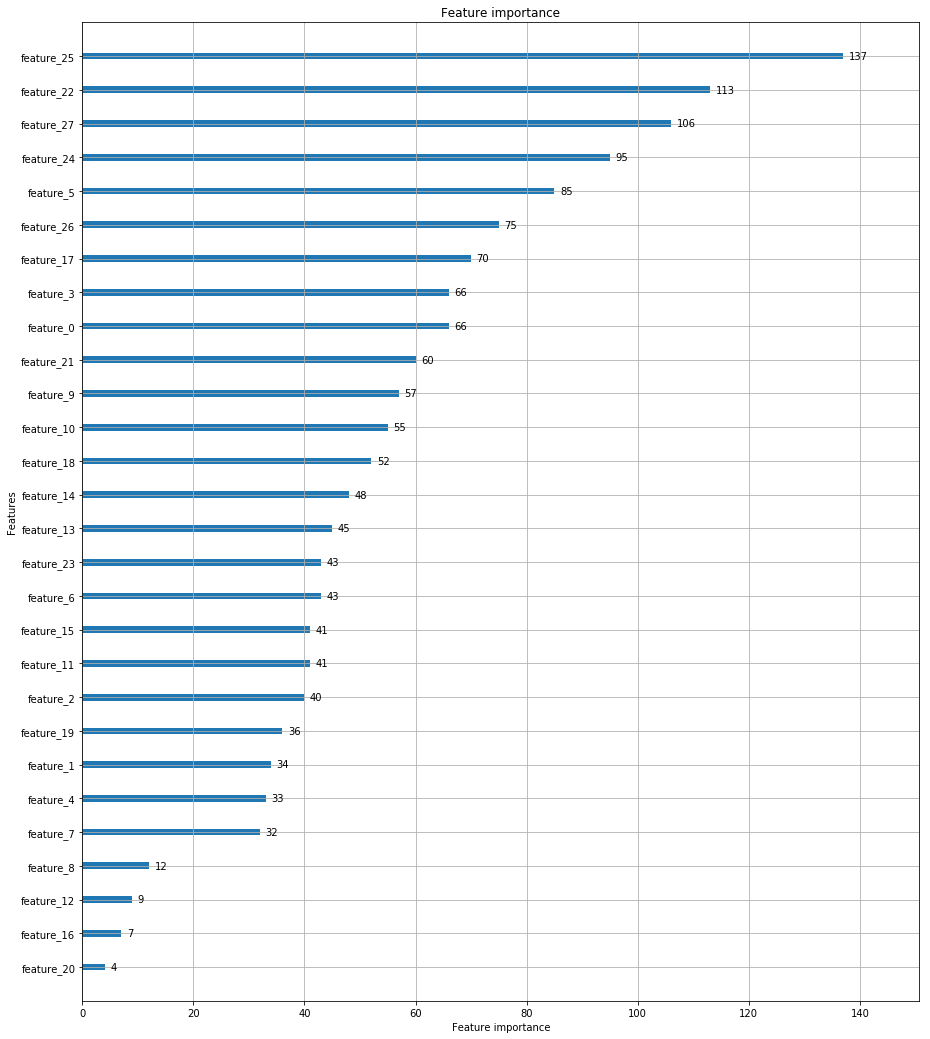

In [14]:
lgb.plot_importance(lgb_model, figsize=(15,18))

In [15]:
lgb_model.booster_.save_model("model")

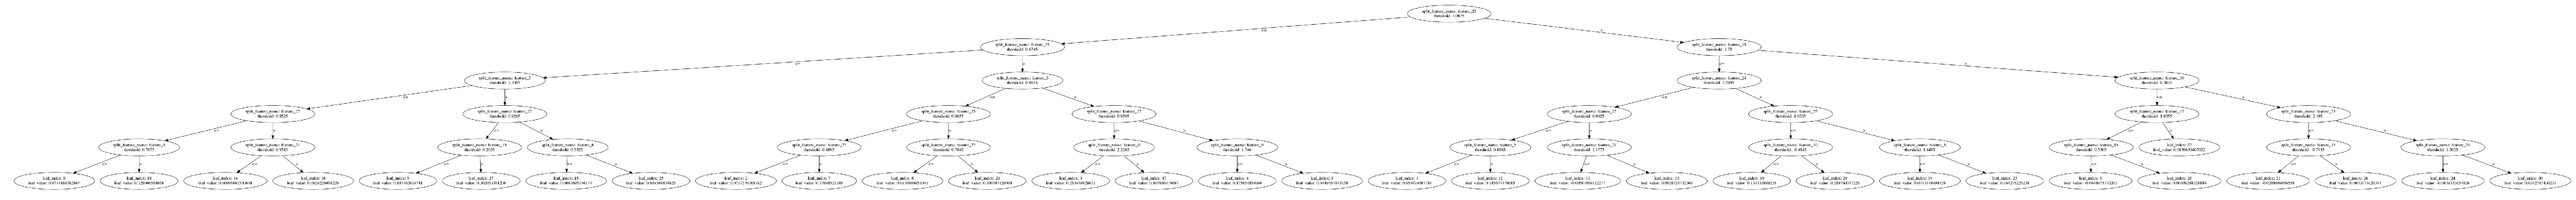

In [16]:
lgb.plot_tree(lgb_model, tree_index=0, figsize=(120,80))

## 2.lgb.train训练

In [17]:
lgb_train = lgb.Dataset(X_train, y_train, weight=W_train, free_raw_data=False)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train, weight=W_test, free_raw_data=False)

In [18]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'lambda_l1': 0.25,
    'lambda_l2': 0.25,
    'verbose': 0,
    'n_estimators': 5000,
    'category_feature': ['feature_20'],  # 指定类别特征
    'n_jobs': 32
}

In [19]:
lgb_model = lgb.train(params,
                lgb_train,
                early_stopping_rounds=50,
                valid_sets=[lgb_train, lgb_eval],  # eval training data
                feature_name=feature_name)

/opt/pythonenvs-dev/ahi_data_analytics/lib/python2.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's auc: 0.768909	valid_1's auc: 0.768322
Training until validation scores don't improve for 50 rounds.
[2]	training's auc: 0.784193	valid_1's auc: 0.757619
[3]	training's auc: 0.798679	valid_1's auc: 0.780938
[4]	training's auc: 0.805172	valid_1's auc: 0.7869
[5]	training's auc: 0.81397	valid_1's auc: 0.795767
[6]	training's auc: 0.819936	valid_1's auc: 0.792579
[7]	training's auc: 0.822798	valid_1's auc: 0.797737
[8]	training's auc: 0.826764	valid_1's auc: 0.799993
[9]	training's auc: 0.828602	valid_1's auc: 0.799317
[10]	training's auc: 0.830831	valid_1's auc: 0.797613
[11]	training's auc: 0.833602	valid_1's auc: 0.800352
[12]	training's auc: 0.83527	valid_1's auc: 0.801143
[13]	training's auc: 0.837782	valid_1's auc: 0.802924
[14]	training's auc: 0.840404	valid_1's auc: 0.804063
[15]	training's auc: 0.842686	valid_1's auc: 0.803599
[16]	training's auc: 0.84454	valid_1's auc: 0.803127
[17]	training's auc: 0.847338	valid_1's auc: 0.803407
[18]	training's auc: 0.850757	vali

In [20]:
lgb_model.best_iteration

89

In [21]:
params["n_estimators"] = lgb_model.best_iteration

In [22]:
lgb_model = lgb.train(params,
                lgb_train,
                valid_sets=[lgb_train],  # eval training data
                feature_name=feature_name)

[1]	training's auc: 0.768909
[2]	training's auc: 0.784193
[3]	training's auc: 0.798679
[4]	training's auc: 0.805172
[5]	training's auc: 0.81397
[6]	training's auc: 0.819936
[7]	training's auc: 0.822798
[8]	training's auc: 0.826764
[9]	training's auc: 0.828602
[10]	training's auc: 0.830831
[11]	training's auc: 0.833602
[12]	training's auc: 0.83527
[13]	training's auc: 0.837782
[14]	training's auc: 0.840404
[15]	training's auc: 0.842686
[16]	training's auc: 0.84454
[17]	training's auc: 0.847338
[18]	training's auc: 0.850757
[19]	training's auc: 0.852948
[20]	training's auc: 0.855607
[21]	training's auc: 0.858282
[22]	training's auc: 0.861073
[23]	training's auc: 0.863758
[24]	training's auc: 0.866083
[25]	training's auc: 0.869147
[26]	training's auc: 0.870969
[27]	training's auc: 0.872342
[28]	training's auc: 0.873986
[29]	training's auc: 0.875678
[30]	training's auc: 0.878184
[31]	training's auc: 0.879931
[32]	training's auc: 0.881545
[33]	training's auc: 0.883439
[34]	training's auc: 0

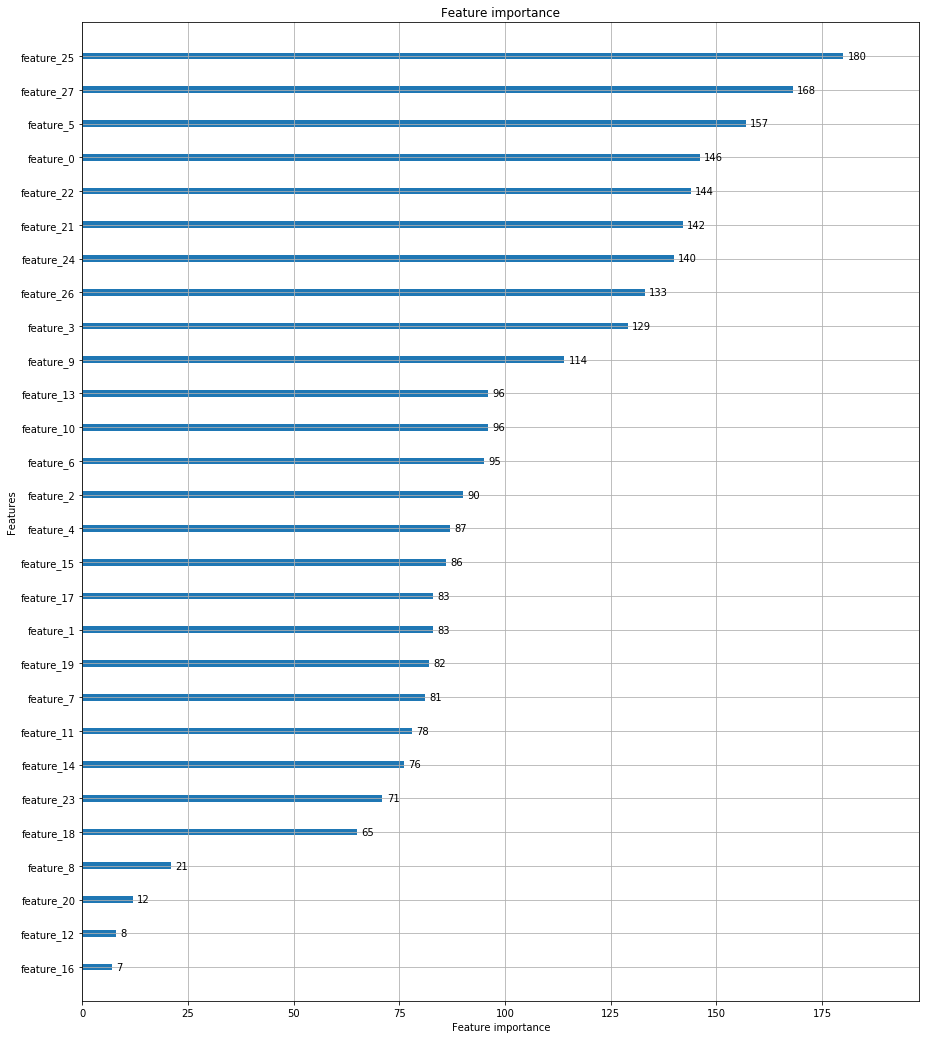

In [23]:
lgb.plot_importance(lgb_model, figsize=(15,18))

In [24]:
lgb_model.save_model("model")

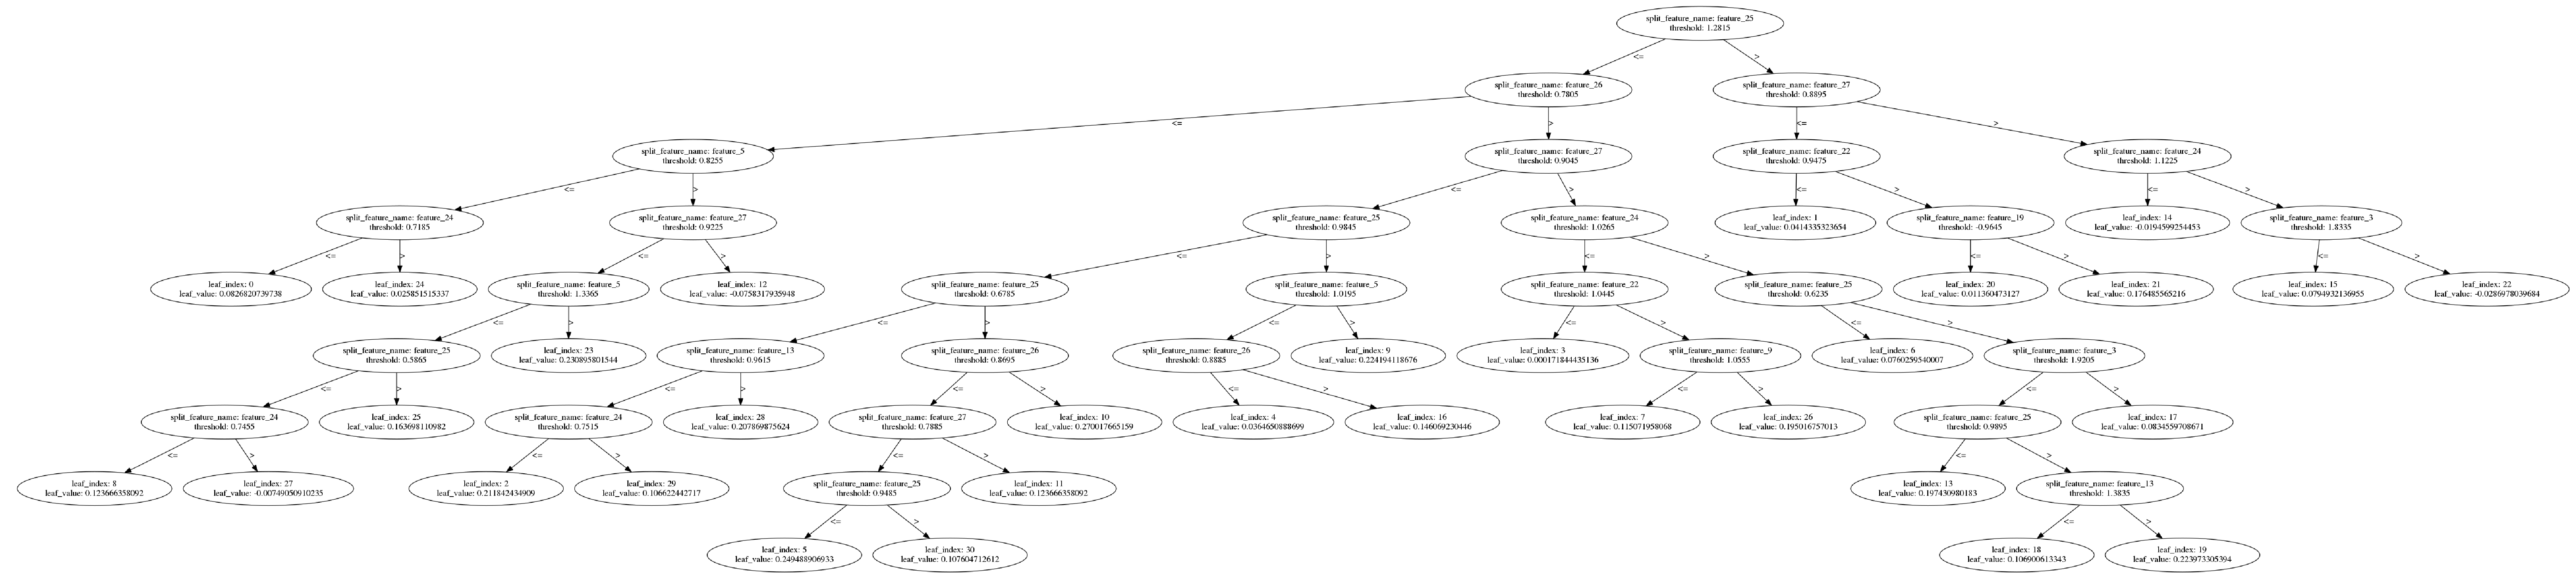

In [25]:
lgb.plot_tree(lgb_model, tree_index=0, figsize=(120,80))

## 3.lgb predict

In [26]:
bst = lgb.Booster(model_file='model')

In [27]:
# 预测
predicted_result = bst.predict(X_test)
predicted_result[:5]

array([0.79729895, 0.41528978, 0.20474307, 0.50277215, 0.10389262])

In [28]:
# shap  注：最后一列是特征贡献度的期望值
shap = bst.predict(X_test, pred_contrib=True)
shap[:5]

array([[ 3.58961258e-02,  2.55980530e-03,  6.35728244e-03,
         2.60458074e-03,  6.13328572e-03, -1.58237986e-01,
         4.34385625e-02,  5.38400494e-02, -4.31149131e-02,
        -5.96408590e-03, -2.10808352e-02,  6.27483747e-02,
         1.74027468e-03,  4.76470023e-01, -4.76846230e-02,
        -4.10389741e-02,  1.80262692e-02,  3.69408155e-02,
        -2.39396053e-02, -3.39528856e-03, -1.46079968e-02,
         8.35521370e-02,  1.97244473e-01, -4.32643337e-03,
        -1.95378807e-01, -2.08103523e-01,  3.58304103e-01,
         5.81071687e-01,  1.69442693e-01],
       [ 2.46579153e-01, -1.06808351e-01,  4.63754856e-02,
         1.39634413e-01,  3.33981605e-02,  3.83052800e-01,
        -2.85797118e-02, -3.39388276e-02, -1.89431906e-02,
        -2.64145852e-02, -2.31357704e-01, -4.51716554e-03,
         6.99120671e-04,  1.80545902e-01,  1.56784437e-02,
        -1.16537261e-02, -6.70226189e-02, -2.30681160e-02,
        -6.22128785e-02,  4.70003153e-03, -9.55481937e-03,
         3.91